# Stanford Cars dataset

## Import libraries

In [1]:
from tensorflow.keras.preprocessing import sequence
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPool1D, Dropout, SimpleRNN, LSTM, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import string
import pandas as pd
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical# This Python 3 environment comes with many helpful analytics libraries installed

## Data Train

In [2]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot

In [3]:
data_dir = "stanford_cars/cars_train/cars_train/"
X_train = []
y_train = []
X_test = []
y_test = []
# Parcourir tous les fichiers dans le dossier
for filename in os.listdir(data_dir):
    # Charger l'image
    img = cv2.imread(os.path.join(data_dir, filename))
    label = filename.split('_')[0]
    if np.random.rand() < 0.5:
        if img is not None:
            img = cv2.resize(img, (32,32))
            X_train.append(img)
            y_train.append(label)
    else:
        if img is not None:
            img = cv2.resize(img, (32,32))
            X_test.append(img)
            y_test.append(label)
# Convertir les listes en tableaux NumPy pour pouvoir les utiliser avec TensorFlow
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train/255
X_test = X_test/255
print(len(X_train))

781


## Auto Encoder


In [4]:
X_train.shape

(781, 32, 32, 3)

In [5]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


input_img = Input(shape=(32,32,3))
encoded = Conv2D(32,(5,5), name='e1',activation='relu', padding = 'same')(input_img)
encoded= MaxPooling2D(pool_size = (2, 2))(encoded)
encoded = Conv2D(64,(5,5), name='e2', activation='relu', padding = 'same')(encoded)
encoded = MaxPooling2D(pool_size=(2, 2))(encoded)
encoded = Conv2D(128,(5,5), name='e3', activation='relu', padding = 'same')(encoded)
encoded = MaxPooling2D(pool_size=(2, 2))(encoded)
encoded = Conv2D(64,(5,5), name='e4', activation='relu', padding = 'same')(encoded)



decoded = Conv2D(32,(5,5), name='d1', activation='relu' ,padding = 'same')(encoded)
decoded = UpSampling2D(name='u1')(decoded)
decoded = Conv2D(64,(5,5), name='d2', activation='relu' ,padding = 'same')(decoded)
decoded = UpSampling2D(name='u2')(decoded)
decoded = Conv2D(128,(5,5), name='d3', activation='relu' ,padding = 'same')(decoded)
decoded = UpSampling2D(name='u3')(decoded)
decoded = Conv2D(128,(5,5), name='d4', activation='relu' ,padding = 'same')(decoded)
decoded = Conv2D(3,(5,5), name='d5',  activation='sigmoid', padding = 'same')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 e1 (Conv2D)                 (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 e2 (Conv2D)                 (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 e3 (Conv2D)                 (None, 8, 8, 128)         2049

In [6]:
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 e1 (Conv2D)                 (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 e2 (Conv2D)                 (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 e3 (Conv2D)                 (None, 8, 8, 128)         2049

In [7]:
encoded_input = Input(shape=(4,4,64))
decoder_layer = autoencoder.get_layer('d1')(encoded_input)
decoder_layer = autoencoder.get_layer('u1')(decoder_layer)
decoder_layer = autoencoder.get_layer('d2')(decoder_layer)
decoder_layer = autoencoder.get_layer('u2')(decoder_layer)
decoder_layer = autoencoder.get_layer('d3')(decoder_layer)
decoder_layer = autoencoder.get_layer('u3')(decoder_layer)
decoder_layer = autoencoder.get_layer('d4')(decoder_layer)
decoder_layer = autoencoder.get_layer('d5')(decoder_layer)

decoder = Model(encoded_input, decoder_layer)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 64)]        0         
                                                                 
 d1 (Conv2D)                 (None, 4, 4, 32)          51232     
                                                                 
 u1 (UpSampling2D)           (None, 8, 8, 32)          0         
                                                                 
 d2 (Conv2D)                 (None, 8, 8, 64)          51264     
                                                                 
 u2 (UpSampling2D)           (None, 16, 16, 64)        0         
                                                                 
 d3 (Conv2D)                 (None, 16, 16, 128)       204928    
                                                                 
 u3 (UpSampling2D)           (None, 32, 32, 128)       0   

In [8]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
autoencoder.fit(X_train, X_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/40

4/4 [==============================] - 11s 2s/step - loss: 0.7508 - val_loss: 0.6929
Epoch 2/40
4/4 [==============================] - 9s 2s/step - loss: 0.6931 - val_loss: 0.6927
Epoch 3/40
4/4 [==============================] - 11s 3s/step - loss: 0.6925 - val_loss: 0.6886
Epoch 4/40
4/4 [==============================] - 12s 3s/step - loss: 0.6881 - val_loss: 0.6780
Epoch 5/40
4/4 [==============================] - 15s 4s/step - loss: 0.6808 - val_loss: 0.6696
Epoch 6/40
4/4 [==============================] - 13s 3s/step - loss: 0.6755 - val_loss: 0.6654
Epoch 7/40
4/4 [==============================] - 11s 3s/step - loss: 0.6715 - val_loss: 0.6660
Epoch 8/40
4/4 [==============================] - 11s 3s/step - loss: 0.6729 - val_loss: 0.6596
Epoch 9/40
4/4 [==============================] - 10s 3s/step - loss: 0.6649 - val_loss: 0.6570
Epoch 10/40
4/4 [==============================] - 10s 3s/step - loss: 0.6579 - val_loss: 0.6467
Epoch 11/40
4/4 [======================

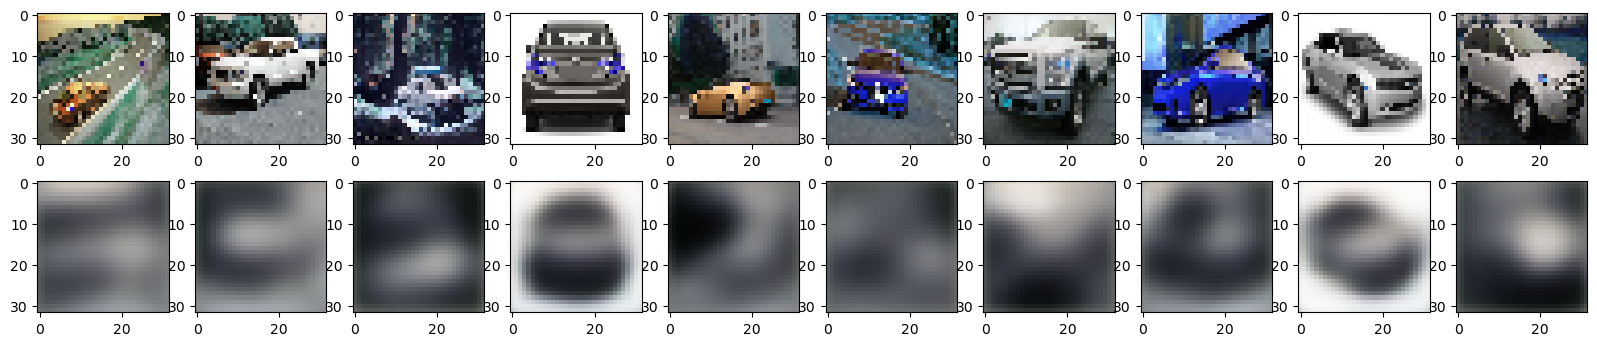

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=10,figsize=(20, 4))
plt.gray()
for indice, row in enumerate(ax):
    for indice2, col in enumerate(row):
        if indice == 0:
            col.imshow(X_test[indice2].reshape(32,32,3))
        else:
            col.imshow(decoded_imgs[indice2].reshape(32,32,3))

plt.show()

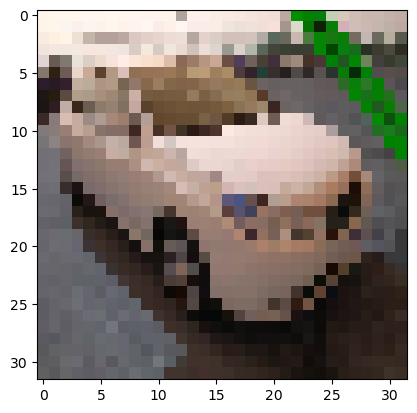

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.imshow(X_test[54].reshape(32,32,3))
plt.gray()
plt.show()

## Cosine similarity

In [12]:
img_to_find = encoded_imgs[10]

In [13]:
img_to_find.shape

(4, 4, 64)

In [14]:
def custom_cosine_sim(a,b):
    return np.dot(a, b) / ( np.linalg.norm(a) * np.linalg.norm(b))

In [16]:
from scipy import spatial 
cosine_list = []
for index_image,xt in enumerate(encoded_imgs):
    result = 1 - spatial.distance.cosine(img_to_find.reshape(-1), xt.reshape(-1))
    cosine_list.append(dict({'res':result, 'i':index_image}))

In [17]:
from operator import itemgetter
cosine_list.sort(key=itemgetter('res'), reverse=True)

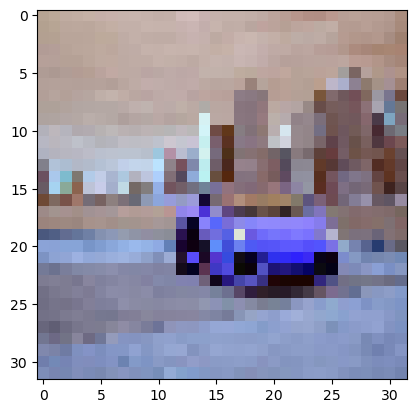

10
281
680
99
487
172
100
370
610
329


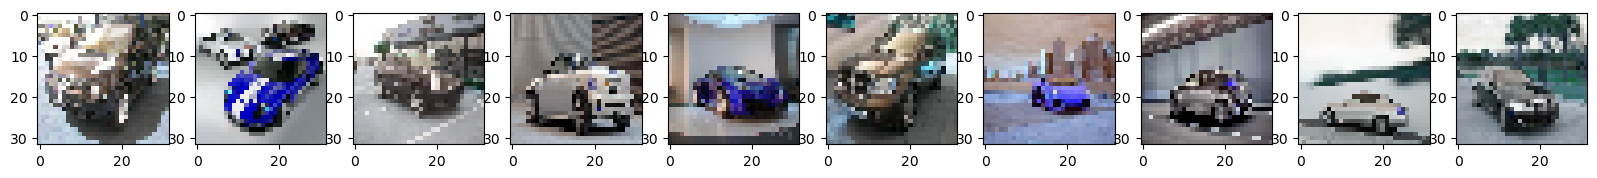

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_test[100].reshape(32,32,3))
plt.gray()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=10,figsize=(20, 4))
plt.gray()
for indice, row in enumerate(ax):
    print (cosine_list[indice]['i'])
    row.imshow(X_test[cosine_list[indice]['i']].reshape(32,32,3))

plt.show()

## Pre-trained cosine

In [20]:
import numpy as np
import cv2
import os
import glob
import gc

def lire_images(img_dir, xdim, ydim,nmax=5000) :
    label = 0
    label_names = []
    X = []
    y=[]
    print(img_dir)
    label_names.append(img_dir)
    data_path = os.path.join(img_dir ,'*g')
    files = glob.glob(data_path)
    n=0
    for f1 in files:
        if n>nmax : break
        try:
            img = cv2.imread(f1) # Lecture de l'image dans le repertoire
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Conversion couleur RGB
            img = cv2.resize(img, (xdim,ydim)) # Redimensionnement de l'image
            X.append(np.array(img)) # Conversion en tableau et ajout a la liste des images
            y.append(label) # Ajout de l'etiquette de l'image a la liste des etiquettes
        except :
            continue
        n=n+1
    print(n,' images lues')
    label = label+1
    X = np.array(X)
    y = np.array(y)
    
    gc.collect() # Récupération de mémoire
    return X,y, label, label_names

In [21]:
X,y,Nombre_classes,Classes = lire_images(data_dir, 32, 32,5000)

stanford_cars/cars_train/cars_train/
1500  images lues


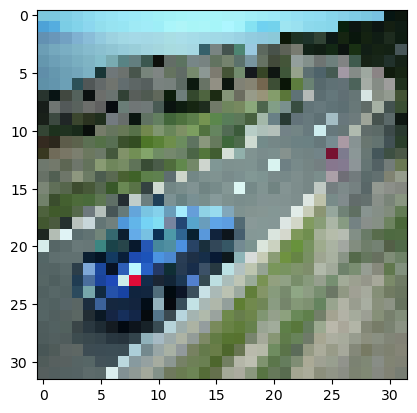

In [22]:
from matplotlib import pyplot as plt
plt.imshow(X[1])

In [32]:
X_train = X[:1000]
X_test = X[1000:]
X_train=X_train
X_test= X_test

In [33]:
import tensorflow as tf
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)

In [34]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 74, 74, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 74, 74, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 74, 74, 32)           0         ['batch_normalizati

                                                                                                  
 conv2d_199 (Conv2D)         (None, 16, 16, 32)           6144      ['average_pooling2d_18[0][0]']
                                                                                                  
 batch_normalization_193 (B  (None, 16, 16, 64)           192       ['conv2d_193[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_195 (B  (None, 16, 16, 64)           192       ['conv2d_195[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_198 (B  (None, 16, 16, 96)           288       ['conv2d_198[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_205 (Activation  (None, 16, 16, 96)           0         ['batch_normalization_205[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_206 (Activation  (None, 16, 16, 64)           0         ['batch_normalization_206[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 16, 16, 288)          0         ['activation_200[0][0]',      
                                                                     'activation_202[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_216 (Conv2D)         (None, 16, 16, 96)           55296     ['activation_215[0][0]']      
                                                                                                  
 batch_normalization_216 (B  (None, 16, 16, 96)           288       ['conv2d_216[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_216 (Activation  (None, 16, 16, 96)           0         ['batch_normalization_216[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_21

                                                                                                  
 conv2d_218 (Conv2D)         (None, 7, 7, 192)            147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_221 (Conv2D)         (None, 7, 7, 192)            172032    ['activation_220[0][0]']      
                                                                                                  
 conv2d_226 (Conv2D)         (None, 7, 7, 192)            172032    ['activation_225[0][0]']      
                                                                                                  
 conv2d_227 (Conv2D)         (None, 7, 7, 192)            147456    ['average_pooling2d_21[0][0]']
                                                                                                  
 batch_normalization_218 (B  (None, 7, 7, 192)            576       ['conv2d_218[0][0]']          
 atchNorma

 activation_235 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_235[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_22 (Aver  (None, 7, 7, 768)            0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_228 (Conv2D)         (None, 7, 7, 192)            147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_231 (Conv2D)         (None, 7, 7, 192)            215040    ['activation_230[0][0]']      
                                                                                                  
 conv2d_23

 atchNormalization)                                                                               
                                                                                                  
 activation_240 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_240[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_245 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_245[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_23 (Aver  (None, 7, 7, 768)            0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_250 (B  (None, 7, 7, 192)            576       ['conv2d_250[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_255 (B  (None, 7, 7, 192)            576       ['conv2d_255[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_250 (Activation  (None, 7, 7, 192)            0         ['batch_normalization_250[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_259 (Conv2D)         (None, 3, 3, 320)            552960    ['activation_258[0][0]']      
                                                                                                  
 conv2d_263 (Conv2D)         (None, 3, 3, 192)            331776    ['activation_262[0][0]']      
                                                                                                  
 batch_normalization_259 (B  (None, 3, 3, 320)            960       ['conv2d_259[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_263 (B  (None, 3, 3, 192)            576       ['conv2d_263[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_270 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_270[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_271 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_271[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_272 (B  (None, 3, 3, 192)            576       ['conv2d_272[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_276 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_276[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_279 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_279[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_280 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_280[0][0
 )                                                                  ]']                           
          

In [35]:
new_test = []
for x in X_test:
    new_test.append(cv2.resize(x, (150,150)))
new_test = np.array(new_test)
new_test.shape

(500, 150, 150, 3)

In [36]:
pred = base_model.predict(new_test)

16/16 [==============================] - 5s 231ms/step


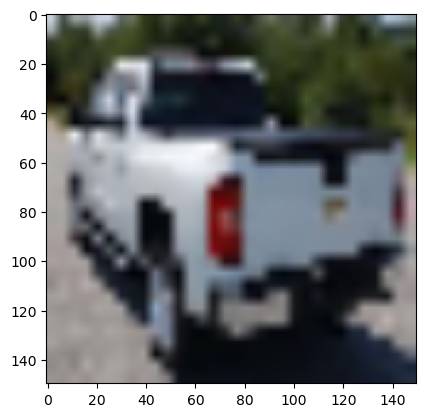

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

index = 1
plt.imshow(new_test[index].reshape(150,150,3))
plt.gray()
plt.show()

In [38]:
img_to_find = pred[index]

In [39]:
from scipy import spatial 
cosine_list = []
for index_image,xt in enumerate(pred):
    result = 1 - spatial.distance.cosine(img_to_find.reshape(-1), xt.reshape(-1))
    cosine_list.append(dict({'res':result, 'i':index_image}))

In [40]:
from operator import itemgetter
cosine_list.sort(key=itemgetter('res'), reverse=True)

1
226
415
112
60
193
178
236
383
309


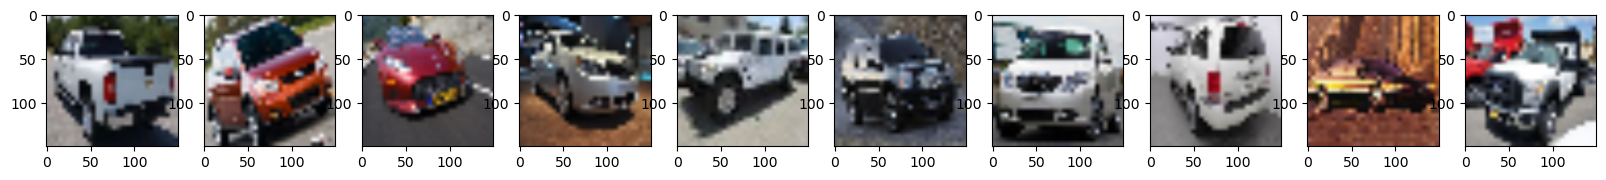

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=10,figsize=(20, 4))
plt.gray()
for indice, row in enumerate(ax):
    print (cosine_list[indice]['i'])
    row.imshow(new_test[cosine_list[indice]['i']].reshape(150,150,3))

plt.show()